# 1. Logistic Regression
## 1-1. Sentiment Analysis

# 2. Text Classification with Deep Neural Networks
## 2-1. Dense Layer
For more details about `tensorflow.keras.preprocessing.text.Tokenizer` and its `texts_to_sequences` & `texts_to_matrix` methods, check the `text_preprocessing` notebook. 

In [177]:
# Construct a pandas DataFrame using `read()`
import pandas as pd

df = pd.read_csv("./datasets/bbc_text_cls.csv")
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [178]:
shuffled_df = df.sample(frac=1).reset_index(drop=True)
shuffled_df.head()

,text,labels
0,Moya fights back for Indian title\n\nCarlos Mo...,sport
1,India and Russia in energy talks\n\nIndia and ...,business
2,Lib Dems' 'bold' election policy\n\nCharles Ke...,politics
3,Gadget market 'to grow in 2005'\n\nThe explosi...,tech
4,Hewitt fights back to reach final\n\nLleyton H...,sport


In [179]:
train_size = int(len(df) * 0.8)
print("Train Size: %d" % train_size)
print("Test Size: %d" % (len(df) - train_size))

Train Size: 1780
Test Size: 445


In [180]:
def train_test_split(df, train_size):
    train = df[:train_size]
    test = df[train_size:]
    return train, test

train_labels, test_labels = train_test_split(shuffled_df["labels"], train_size)
train_text, test_text = train_test_split(shuffled_df["text"], train_size)
print("Train Labels Size:", len(train_labels))
print("Test Labels Size:", len(test_labels))
print("Train Text Size:", len(train_text))
print("Test Text Size:", len(test_text))

Train Labels Size: 1780
Test Labels Size: 445
Train Text Size: 1780
Test Text Size: 445


In [181]:
# `texts_to_matrix()`
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(oov_token="<oov>")

sentences = ["The fool doth think he is wise, but the wise man knows himself to be a fool."]
print("Sample Sentences:", sentences)

tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(sentences)
matrix = tokenizer.texts_to_matrix(sentences, mode="binary")
print("word_index:", word_index)
print("texts_to_sequence:", sequences)
print("texts_to_matrix:", matrix)

Sample Sentences: ['The fool doth think he is wise, but the wise man knows himself to be a fool.']
word_index: {'<oov>': 1, 'the': 2, 'fool': 3, 'wise': 4, 'doth': 5, 'think': 6, 'he': 7, 'is': 8, 'but': 9, 'man': 10, 'knows': 11, 'himself': 12, 'to': 13, 'be': 14, 'a': 15}
texts_to_sequence: [[2, 3, 5, 6, 7, 8, 4, 9, 2, 4, 10, 11, 12, 13, 14, 15, 3]]
texts_to_matrix: [[0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [182]:
max_words = 1000
tokenize = Tokenizer(num_words=max_words, char_level=False)

tokenize.fit_on_texts(train_text)
X_train = tokenize.texts_to_matrix(train_text)
X_test = tokenize.texts_to_matrix(test_text)
print('X_train Shape:', X_train.shape)
print('X_test Shape:', X_test.shape)

X_train Shape: (1780, 1000)
X_test Shape: (445, 1000)


In [183]:
# Use `sklearn` utility to convert label strings to numbered index
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(train_labels)
y_train = encoder.transform(train_labels)
y_test = encoder.transform(test_labels)
print("y_train Unique Labels:", len(set(y_train)))
print("y_test Unique Labels:", len(set(y_test)))

y_train Unique Labels: 5
y_test Unique Labels: 5


In [184]:
# Convert the labels to a one-hot representation
import numpy as np
import keras

num_classes = np.max(y_train) + 1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('y_train Shape:', y_train.shape)
print('y_test Shape:', y_test.shape)

y_train Shape: (1780, 5)
y_test Shape: (445, 5)


In [185]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Remember convert NumPy array to PyTorch tensor or the `TypeError: 'int' object is not callable` error will show up
X_train = torch.Tensor(X_train).to(device)
X_test = torch.Tensor(X_test).to(device)
y_train = torch.Tensor(y_train).to(device)
y_test = torch.Tensor(y_test).to(device)

# Convert them into `torch.utils.data.TensorDataset` (already converted to tensors)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Translate into `torch.utils.data.dataloader` objects
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])

In [189]:
# Inspect the data & labels inside the dataloader
for data, label in train_dataloader:
    print('Data Shape in Training Set DataLoader:', data.shape)
    print('Sample Data:')
    print(data)
    print('Data Shape in Training Set DataLoader:', label.shape)
    print('Sample Label:')
    print(label)
    break

Data Shape in Training Set DataLoader: torch.Size([32, 1000])
Sample Data:
tensor([[0., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 1., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.]], device='cuda:0')
Data Shape in Training Set DataLoader: torch.Size([32, 5])
Sample Label:
tensor([[0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0.

In [186]:
class TextClassificationDeepNeuralNetwork(torch.nn.Module):
    def __init__(self, dropout_prob):
        super().__init__()

        # Layers
        self.input = torch.nn.Linear(max_words, 512)
        self.output = torch.nn.Linear(512, num_classes)

        # Parameters
        self.dropout_prob = dropout_prob

    # Forward pass
    def forward(self, X):
        # Pass the data through the input layer
        X = torch.nn.functional.relu(self.input(X))
    
        # Dropout after input layer
        # `training=self.training` means to turn off during eval mode
        X = torch.nn.functional.dropout(X, p=self.dropout_prob, training=self.training) 

        # Output layer
        X = self.output(X)
        
        return X

# Make sure to move the model to GPU before constructing the optimizer
model = TextClassificationDeepNeuralNetwork(dropout_prob=0.5).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [187]:
num_epochs = 100
losses = torch.zeros(num_epochs)
train_accuracies = []
test_accuracies = []

# Loop over epochs
for epoch in range(num_epochs):
    # Switch training mode on
    model.train() 

    # Loop over training data batches
    batch_losses = []
    batch_accuracies = []
    for X, y in train_dataloader:
        # forward pass and loss
        y_hat = model(X)
        loss = criterion(y_hat, y)
        # Note that `y` is probabilities not labels
        
        # Back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Loss from this batch
        batch_losses.append(loss.item())
        
        # Compute accuracy
        # Booleans (`True` or `False`)
        matches = torch.argmax(y_hat, axis=1) == torch.argmax(y, axis=1)
        # Convert to numbers (`1` or `0`)
        matches_numeric = matches.float()
        # Average & times `100`
        accuracy_percentage = 100 * torch.mean(matches_numeric)
        # Add to list of accuracies
        batch_accuracies.append(accuracy_percentage.cpu())
        # End of batch loop

    # Now that we've trained through the batches, get their average training accuracy
    # `numpy.mean()` works with list of `torch.Tensor`
    train_accuracies.append(np.mean(batch_accuracies))

    # Get average losses across the batches
    losses[epoch] = np.mean(batch_losses)

    # Test accuracy
    # Switch training off
    model.eval() 
    # Extract X, y from test dataloader
    X, y = next(iter(test_dataloader)) 
    y_hat = model(X)
    test_accuracies.append(100 * torch.mean(((y_hat > 0) == y).float()).item())

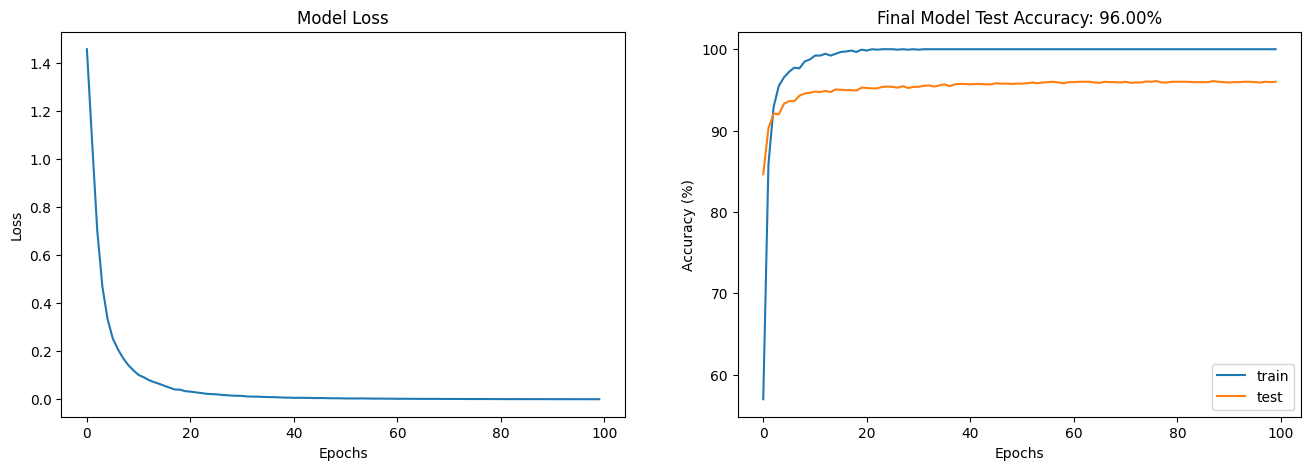

In [188]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
# ax[0].set_ylim([0, 1])
ax[0].set_title('Model Loss')

ax[1].plot(train_accuracies, label='train')
ax[1].plot(test_accuracies, label='test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
# ax[1].set_ylim([10, 100])
ax[1].set_title(f'Final Model Test Accuracy: {test_accuracies[-1]:.2f}%')
ax[1].legend()

plt.show()

## 2-2. Embedding Layer
One-hot encoding followed by a dense layer is the same as a single **Embedding Layer** which allows the processing & reduction of high-dimensional (vocabulary size) categorical data into a lower-dimensional (context length) space but also leads to the requirement of padding or truncation.  

1. `torch.nn.Embedding(num_embeddings, embedding_dim, padding_idx=None, max_norm=None, norm_type=2.0, scale_grad_by_freq=False, sparse=False, _weight=None, _freeze=False, device=None, dtype=None)`: A simple lookup table that stores embeddings of a fixed dictionary and size.

# 3. Text Classification with BERT
Fine-tune BERT for sequence classification also on GLUE SST-2.

In [1]:
from datasets import load_dataset

raw_datasets = load_dataset("glue", "sst2")
print(raw_datasets)

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})


In [2]:
print(raw_datasets['train'])

Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 67349
})


In [3]:
print(raw_datasets['train'].data)

MemoryMappedTable
sentence: string
label: int64
idx: int32
----
sentence: [["hide new secretions from the parental units ","contains no wit , only labored gags ","that loves its characters and communicates something rather beautiful about human nature ","remains utterly satisfied to remain the same throughout ","on the worst revenge-of-the-nerds clichés the filmmakers could dredge up ",...,"you wish you were at home watching that movie instead of in the theater watching this one ","'s no point in extracting the bare bones of byatt 's plot for purposes of bland hollywood romance ","underdeveloped ","the jokes are flat ","a heartening tale of small victories "],["suspense , intriguing characters and bizarre bank robberies , ","a gritty police thriller with all the dysfunctional family dynamics one could wish for ","with a wonderful ensemble cast of characters that bring the routine day to day struggles of the working class to life ","nonetheless appreciates the art and reveals a music sc

In [4]:
print(raw_datasets['train'].features)

{'sentence': Value(dtype='string', id=None), 'label': ClassLabel(names=['negative', 'positive'], id=None), 'idx': Value(dtype='int32', id=None)}


In [5]:
from transformers import AutoTokenizer
from pprint import pprint

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenized_sentences = tokenizer(raw_datasets['train'][0:3]['sentence'])
pprint(tokenized_sentences)

{'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
 'input_ids': [[101, 5342, 2047, 3595, 8496, 2013, 1996, 18643, 3197, 102],
               [101,
                3397,
                2053,
                15966,
                1010,
                2069,
                4450,
                2098,
                18201,
                2015,
                102],
               [101,
                2008,
                7459,
                2049,
                3494,
                1998,
                10639,
                2015,
                2242,
                2738,
                3376,
                2055,
                2529,
                3267,
                102]],
 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}


/home/yungshun317/envs/yungshun-py3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
def tokenize_fn(batch):
    return tokenizer(batch['sentence'], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_fn, batched=True)
type(tokenized_datasets)

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

datasets.dataset_dict.DatasetDict

In [15]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  'my_trainer',
  eval_strategy='epoch',
  save_strategy='epoch',
  num_train_epochs=3,
)
print(training_args)

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPOCH,
eval_use_gather_object=False,
evaluation_s

In [16]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
print(type(model))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'>


In [17]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [18]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                       Param #
BertForSequenceClassification                                --
├─BertModel: 1-1                                             --
│    └─BertEmbeddings: 2-1                                   --
│    │    └─Embedding: 3-1                                   23,440,896
│    │    └─Embedding: 3-2                                   393,216
│    │    └─Embedding: 3-3                                   1,536
│    │    └─LayerNorm: 3-4                                   1,536
│    │    └─Dropout: 3-5                                     --
│    └─BertEncoder: 2-2                                      --
│    │    └─ModuleList: 3-6                                  85,054,464
│    └─BertPooler: 2-3                                       --
│    │    └─Linear: 3-7                                      590,592
│    │    └─Tanh: 3-8                                        --
├─Dropout: 1-2                                               --
├─L

In [19]:
# !pip3 install evaluate
import evaluate

# Metric for validation error
def compute_metrics(eval_preds):
    metric = evaluate.load("glue", "sst2")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [20]:
from transformers import Trainer
import numpy as np

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.273700,0.376256,0.899083
2,0.181900,0.376520,0.908257
3,0.095100,0.399332,0.910550


TrainOutput(global_step=25257, training_loss=0.20752819750151064, metrics={'train_runtime': 1008.3073, 'train_samples_per_second': 200.382, 'train_steps_per_second': 25.049, 'total_flos': 3082513027395900.0, 'train_loss': 0.20752819750151064, 'epoch': 3.0})

In [22]:
trainer.save_model('models/sst2_bert')

In [24]:
from transformers import pipeline

finetuned_model = pipeline("text-classification", model='models/sst2_bert', device=0)
finetuned_model('This is such a great movie!')

[{'label': 'LABEL_1', 'score': 0.9997673630714417}]

In [25]:
finetuned_model('This is such a bad movie!')

[{'label': 'LABEL_0', 'score': 0.9991169571876526}]

In [27]:
!cat models/sst2_bert/config.json

{
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.44.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [28]:
metric = evaluate.load("glue", "sst2")

n_samples = 500

# The labels in test set of `glue/sst2` are `-1`
X = raw_datasets['train'].data["sentence"].to_pylist()[:n_samples]
y = raw_datasets['train'].data["label"].to_pylist()[:n_samples]

results = finetuned_model(X)
predictions = [0 if res["label"] == "LABEL_0" else 1 for res in results]
print(metric.compute(predictions=predictions, references=y))

{'accuracy': 0.99}
